In [1]:
# Imports
from config import *
from utils.fetch import fetch_recent_arxiv
from utils.filter import filter_papers_by_keywords, extract_multi_tier_matches
from utils.heatmap import build_keyword_heatmap
from widgets.interface import ArxivKeywordInterface
from keywords.tiers import TIERED_KEYWORDS

In [2]:
import os
import json
import pandas as pd
import time
from datetime import datetime

In [3]:
# Load or initialize scan log
if os.path.exists(SCAN_LOG_FILE):
    with open(SCAN_LOG_FILE, "r") as f:
        scan_log = json.load(f)
else:
    scan_log = {}

In [4]:
# Load existing raw data if present
if os.path.exists(OUTPUT_RAW):
    df_raw = pd.read_csv(OUTPUT_RAW)
    existing_links = set(df_raw["Link"])
else:
    df_raw = pd.DataFrame()
    existing_links = set()

In [5]:
# Fetch new entries from arXiv
from tqdm import tqdm
all_papers = []

for cat in tqdm(CATEGORIES, desc="Scanning Categories"):
    last_scanned = scan_log.get(cat)
    if last_scanned:
        last_scanned_date = datetime.strptime(last_scanned, "%Y-%m-%d")
        if datetime.now() - last_scanned_date < timedelta(days=DAYS_BACK):
            continue

    entries = fetch_recent_arxiv(cat)
    new_papers = 0

    for entry in entries:
        try:
            pub_date = datetime.strptime(entry.published, "%Y-%m-%dT%H:%M:%SZ")
            if pub_date >= DATE_THRESHOLD and entry.link not in existing_links:
                all_papers.append({
                    "Title": entry.title.strip().replace('\n', ' '),
                    "Summary": entry.summary.strip().replace('\n', ' '),
                    "Link": entry.link,
                    "Published": pub_date.date(),
                    "Category": cat
                })
                existing_links.add(entry.link)
                new_papers += 1
        except Exception as e:
            print(f"⚠️ Error: {e}")

    if new_papers > 0:
        print(f"✅ {new_papers} new papers added from {cat}")
    scan_log[cat] = NOW_STR
    time.sleep(SLEEP_BETWEEN_CALLS)

Scanning Categories:   0%|          | 0/33 [00:00<?, ?it/s]

Scanning Categories: 100%|██████████| 33/33 [00:00<00:00, 83886.08it/s]


In [6]:
# Save combined raw data
if all_papers:
    df_new = pd.DataFrame(all_papers)
    df_combined = pd.concat([df_raw, df_new], ignore_index=True)
    df_combined.drop_duplicates(subset="Link", inplace=True)
    df_combined.to_csv(OUTPUT_RAW, index=False)
    with open(SCAN_LOG_FILE, "w") as f:
        json.dump(scan_log, f, indent=2)
else:
    df_combined = df_raw

print(f"📦 Total papers: {len(df_combined)}")

📦 Total papers: 5286


In [7]:
# Filter papers based on tiered keywords
df_filtered = filter_papers_by_keywords(df_combined)
df_filtered.to_csv(OUTPUT_FILTERED, index=False)
print(f"✅ Filtered papers saved to {OUTPUT_FILTERED}")

Filtering Papers: 100%|██████████| 5286/5286 [00:00<00:00, 9104.65it/s]


✅ Filtered papers saved to data/arxiv_recent_filtered.csv


d:\PyProj\ArXiV\utils\heatmap.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = pd.DataFrame(index=tier_keyword_freq.keys(), columns=all_keywords).fillna(0)


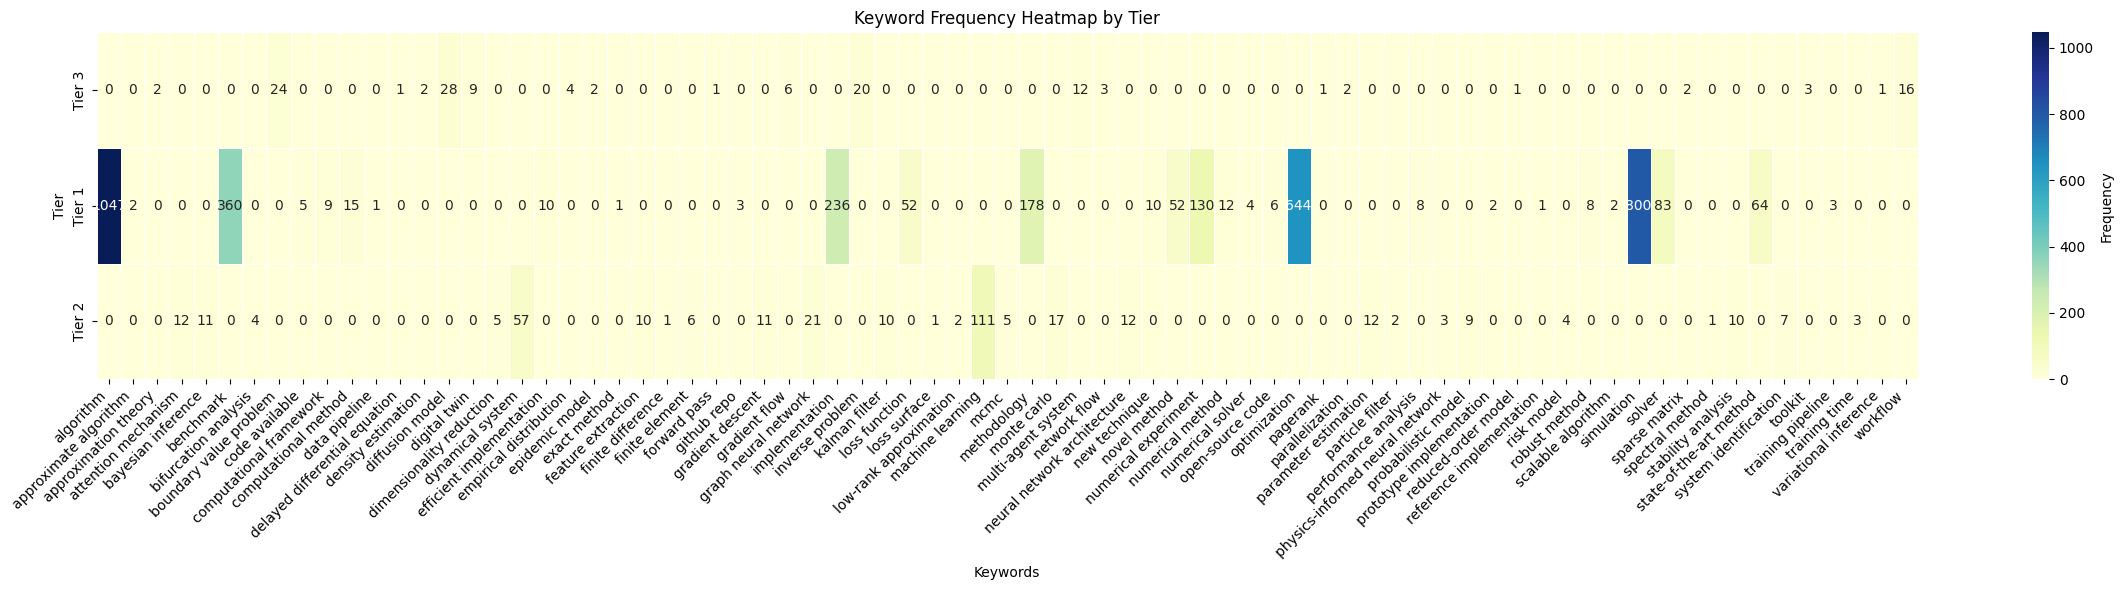

In [8]:
# Optional: Visualize keyword heatmap
build_keyword_heatmap(df_filtered)

In [9]:
# Generate multi-tier keyword data
df_keywords = extract_multi_tier_matches(df_combined)
df_keywords.to_csv(OUTPUT_MULTI, index=False)
print(f"✅ Multi-tier keyword matches saved to {OUTPUT_MULTI}")

Matching Tiers: 100%|██████████| 5286/5286 [00:00<00:00, 6557.54it/s]


✅ Multi-tier keyword matches saved to data/arxiv_multi_tier_keywords.csv


In [10]:
#from utils.cooccurrence import build_cooccurrence_matrix, plot_cooccurrence_heatmap, build_pyvis_cooccurrence_graph

# Build co-occurrence matrix
#co_matrix = build_cooccurrence_matrix(df_keywords, keyword_col="All Keywords", min_cooccurrence=2)

# Heatmap visualization
#plot_cooccurrence_heatmap(co_matrix)

# Interactive PyVis graph
#build_pyvis_cooccurrence_graph(co_matrix, output_html="cooccurrence_graph.html", threshold=2)


In [11]:
from utils.scoring_utils import apply_scoring
from IPython.display import display, Markdown

df = pd.read_csv("data/arxiv_multi_tier_keywords.csv")
df = apply_scoring(df)
df.to_csv("data/arxiv_multi_tier_keywords.csv", index=False)

top_n = 10
display(Markdown(f"### 🏆 Top {top_n} Highest Scoring Papers"))
display(df.sort_values("Score", ascending=False).head(top_n))

### 🏆 Top 10 Highest Scoring Papers

,Title,Summary,Link,Published,Category,Tier 1 Keywords,Tier 2 Keywords,Tier 3 Keywords,All Keywords,Score
132,Curvature accelerated decentralized non-convex...,We consider distributed optimization as motiva...,http://arxiv.org/abs/2504.04073v1,2025-04-05,math.OC,"algorithm, solver, numerical experiment, optim...","convex optimization, machine learning","quasi-newton, distributed optimization, multi-...","algorithm, convex optimization, distributed op...",22
1889,Multi-Dimensional AGV Path Planning in 3D Ware...,"Within modern warehouse scenarios, the rapid e...",http://arxiv.org/abs/2504.01985v1,2025-03-30,cs.RO,"algorithm, benchmark, optimization, loss funct...",attention mechanism,attention mechanism,"algorithm, attention mechanism, benchmark, los...",18
408,Effective Dimension Aware Fractional-Order Sto...,Fractional-order stochastic gradient descent (...,http://arxiv.org/abs/2503.13764v1,2025-03-17,math.OC,"algorithm, benchmark, optimization, novel method","gradient descent, convex optimization, machine...",NaN,"algorithm, benchmark, convex optimization, gra...",18
2653,A novel gradient-based method for decision tre...,There are many approaches for training decisio...,http://arxiv.org/abs/2503.17855v1,2025-03-22,stat.ML,"algorithm, implementation, numerical experimen...",machine learning,NaN,"algorithm, implementation, loss function, mach...",17
384,Fast MLE and MAPE-Based Device Activity Detect...,Fast and accurate device activity detection is...,http://arxiv.org/abs/2503.15259v2,2025-03-19,math.OC,"algorithm, implementation, optimization, state...","convex optimization, neural network architecture",posterior estimation,"algorithm, convex optimization, implementation...",17
2341,Enhanced Vascular Flow Simulations in Aortic A...,Due to the limited accuracy of 4D Magnetic Res...,http://arxiv.org/abs/2503.17402v1,2025-03-19,stat.CO,"algorithm, simulation, benchmark, loss function",physics-informed neural network,"benchmark dataset, data assimilation","algorithm, benchmark, benchmark dataset, data ...",16
1000,Practical Portfolio Optimization with Metaheur...,Portfolio optimization is a critical area in f...,http://arxiv.org/abs/2503.15965v1,2025-03-20,cs.CE,"algorithm, methodology, benchmark, optimization",portfolio optimization,"metaheuristic, genetic algorithm","algorithm, benchmark, genetic algorithm, metah...",16
2100,Value Gradients with Action Adaptive Search Tr...,Solving Partially Observable Markov Decision P...,http://arxiv.org/abs/2503.12181v1,2025-03-15,cs.RO,"algorithm, solver, methodology, novel method","monte carlo, importance sampling",NaN,"algorithm, importance sampling, methodology, m...",16
121,Nonlinear Robust Optimization for Planning and...,This paper presents a novel robust trajectory ...,http://arxiv.org/abs/2504.04605v1,2025-04-06,math.OC,"algorithm, simulation, methodology, optimization","trajectory optimization, dynamical system",NaN,"algorithm, dynamical system, methodology, opti...",16
1343,Robo-taxi Fleet Coordination at Scale via Rein...,Fleets of robo-taxis offering on-demand transp...,http://arxiv.org/abs/2504.06125v2,2025-04-08,cs.SY,"algorithm, simulation, code available, open-so...",NaN,NaN,"algorithm, benchmark, code available, open-sou...",15


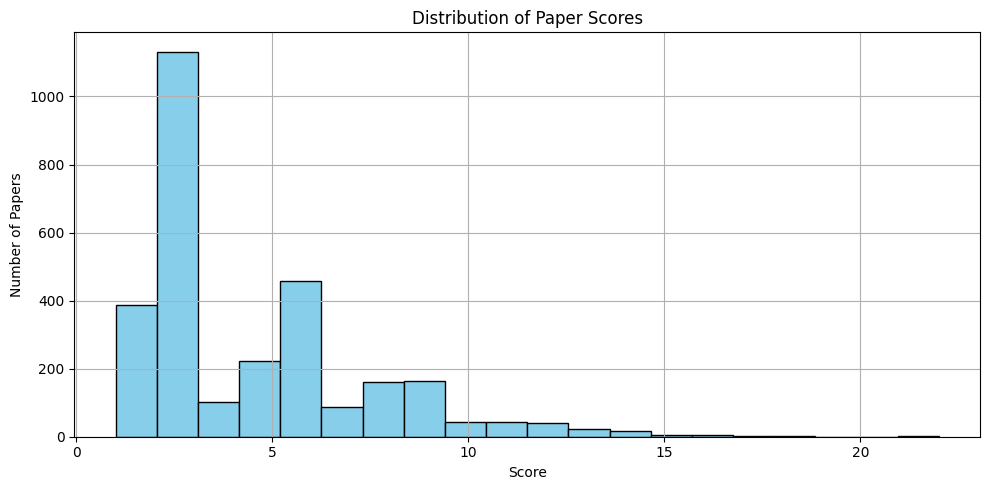

In [12]:
from utils.scoring_utils import plot_score_histogram
plot_score_histogram(df)

In [ ]:
# Launch interface
ArxivKeywordInterface(df)

## 🔍 Build a Filter by Stacking Keywords

Output()

In [17]:
from widgets.library_interface import display_library_interface
display_library_interface("data/arxiv_library.csv")

In [15]:
from widgets.tex_analysis_interface import TexAnalyzer

analyzer = TexAnalyzer()
analyzer.render()

### 🔬 Analyze TeX Content of a Paper